Head:
   id       f01       f02       f03       f04       f05       f06       f07  \
0   1 -1.250210  1.423474 -0.225004 -4.023138 -0.832729 -0.550874  1.772090   
1   2  0.074328  0.376429  0.212831 -0.502074  2.017405  0.625496  1.943785   
2   3  0.638481  0.060968  0.746760  2.479653 -0.292858 -0.078139 -2.918423   
3   4  1.712916 -1.350969 -0.256473  1.622074 -0.445141  0.911932 -3.440345   
4   5  0.905676 -0.206545 -0.068806  4.086026 -1.010045 -0.772644 -4.207688   

        f08       f09  ...        f52        f53       f54       f55  \
0  2.761690 -0.698750  ...  10.938269   0.501178  1.600001  0.314212   
1  1.242030 -0.524090  ...   7.775262  -4.550195  6.272586 -0.932162   
2 -0.013186  1.009135  ...  -4.448447  -9.593179 -3.093519  0.029321   
3  1.505192 -1.104348  ...  -1.619072  -3.237479 -5.474038 -1.582475   
4  2.506104  1.589143  ...  -2.396844 -10.540129 -5.532811 -1.231203   

        f56       f57       f58       f59       f60  target  
0  1.209735  1.355697 -5

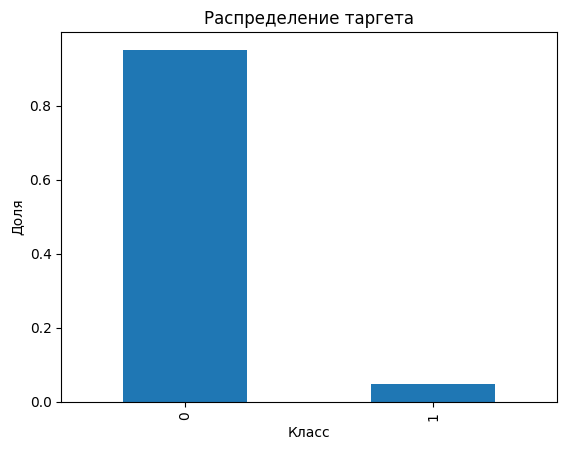

X shape: (25000, 60)
y shape: (25000,)


In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report

import matplotlib.pyplot as plt

df = pd.read_csv("..\\datasets\\S06-hw-dataset-04.csv")

print("Head:")
print(df.head())
print("Info:")
df.info()
print("Describe:")
print(df.describe())
# Проверка пропусков
print("Пропуски:")
print(df.isna().sum())
target_distribution = df['target'].value_counts(normalize=True)
print("Target:")
print(target_distribution)
# Визуализация распределения таргета
plt.figure()
target_distribution.plot(kind='bar')
plt.title("Распределение таргета")
plt.xlabel("Класс")
plt.ylabel("Доля")
print("Визуализация распределения таргета:")
plt.show()
X = df.drop(columns=['target', 'id'])
y = df['target']
print("X shape:", X.shape)
print("y shape:", y.shape)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
# Проверка размерностей
print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (20000, 60) (20000,)
Test: (5000, 60) (5000,)


Фиксированный seed позволяет повторять эксперименты, корректно сравнивать разные модели и гиперпараметры, воспроизводить результаты в отчёте.

Стратификация предотвращает ситуацию, когда в тестовой выборке отсутствует редкий класс или метрики качества оказываются некорректными.

In [5]:
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

#dummy
dummy = DummyClassifier(strategy="most_frequent", random_state=42)
dummy.fit(X_train, y_train)

y_pred_dummy = dummy.predict(X_test)
y_proba_dummy = dummy.predict_proba(X_test)[:, 1]

print("DummyClassifier")
print("Accuracy:", accuracy_score(y_test, y_pred_dummy))
print("F1:", f1_score(y_test, y_pred_dummy))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_dummy))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_dummy))

#LogisticRegression
pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=1000, random_state=42))
])

pipe_lr.fit(X_train, y_train)

y_pred_lr = pipe_lr.predict(X_test)
y_proba_lr = pipe_lr.predict_proba(X_test)[:, 1]

print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("F1:", f1_score(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_lr))


DummyClassifier
Accuracy: 0.9508
F1: 0.0
ROC-AUC: 0.5
Confusion matrix:
 [[4754    0]
 [ 246    0]]
Logistic Regression
Accuracy: 0.9632
F1: 0.42857142857142855
ROC-AUC: 0.8339874679773299
Confusion matrix:
 [[4747    7]
 [ 177   69]]


Decision Tree

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

dt = DecisionTreeClassifier(random_state=42, min_samples_leaf=10)

dt_params = {
    "max_depth": [3, 5, 7, None], # Ограничивает глубину дерева
    "min_samples_leaf": [1, 10, 50] # Запрещает слишком маленькие листья
}

dt_grid = GridSearchCV(
    dt,
    dt_params,
    scoring="f1",
    cv=5,
    n_jobs=-1
)

dt_grid.fit(X_train, y_train)

best_dt = dt_grid.best_estimator_

y_pred_dt = best_dt.predict(X_test)
y_proba_dt = best_dt.predict_proba(X_test)[:, 1]

print("Decision Tree")
print("Best params:", dt_grid.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("F1:", f1_score(y_test, y_pred_dt))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_dt))


Decision Tree
Best params: {'max_depth': None, 'min_samples_leaf': 10}
Accuracy: 0.9676
F1: 0.5970149253731343
ROC-AUC: 0.8283405330898072


Random forest

In [7]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200, # Cтроим 200 деревьев в лесу
    random_state=42,
    n_jobs=-1 # Использовать все доступные CPU
)

rf_params = {
    "max_depth": [None, 5, 10], # Ограничивает глубину каждого дерева
    "min_samples_leaf": [1, 10], # Минимальное число объектов в листе
    "max_features": ["sqrt", "log2"] # Количество признаков, которые дерево смотрит на каждом узле
}

rf_grid = GridSearchCV(
    rf,
    rf_params,
    scoring="f1",
    cv=5,
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)

best_rf = rf_grid.best_estimator_

y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

print("Random Forest")
print("Best params:", rf_grid.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("F1:", f1_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))


Random Forest
Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1}
Accuracy: 0.9738
F1: 0.6391184573002755
ROC-AUC: 0.9019345283902985


Gradient Boosting

In [8]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=42)

gb_params = {
    "n_estimators": [100, 200],      # Cколько деревьев строить
    "learning_rate": [0.05, 0.1],    # Скорость обучения (как сильно каждое дерево исправляет ошибки)
    "max_depth": [3, 5]              # Максимальная глубина каждого дерева
}

gb_grid = GridSearchCV(
    gb,
    gb_params,
    scoring="f1",
    cv=5,
    n_jobs=-1
)

gb_grid.fit(X_train, y_train)

best_gb = gb_grid.best_estimator_

y_pred_gb = best_gb.predict(X_test)
y_proba_gb = best_gb.predict_proba(X_test)[:, 1]

print("Gradient Boosting")
print("Best params:", gb_grid.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_gb))
print("F1:", f1_score(y_test, y_pred_gb))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_gb))


Gradient Boosting
Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Accuracy: 0.9748
F1: 0.7
ROC-AUC: 0.8905346289474674


Интерпретация лучшей модели(Gradient Boosting)

In [9]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(
    best_gb, X_test, y_test,
    n_repeats=10,
    random_state=42,
    scoring='f1'
)

importance_df = pd.DataFrame({
    "feature": X.columns,
    "importance_mean": perm_importance.importances_mean,
    "importance_std": perm_importance.importances_std
}).sort_values(by="importance_mean", ascending=False).head(15)

print("Top-15 признаков по permutation importance:")
print(importance_df)


Top-15 признаков по permutation importance:
   feature  importance_mean  importance_std
57     f58         0.134438        0.009685
24     f25         0.120918        0.011347
52     f53         0.108024        0.010117
53     f54         0.094599        0.010490
46     f47         0.088333        0.009386
12     f13         0.059367        0.008252
32     f33         0.055037        0.009931
37     f38         0.047080        0.010912
10     f11         0.030513        0.010392
7      f08         0.029234        0.007222
40     f41         0.027675        0.010375
3      f04         0.026704        0.007611
26     f27         0.025677        0.006122
42     f43         0.022843        0.005713
15     f16         0.010146        0.005617


Метрики качества

In [10]:
import os
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve,
    precision_recall_curve,
    ConfusionMatrixDisplay
)

os.makedirs("artifacts/figures", exist_ok=True)

def plot_and_save(y_true, y_pred, y_proba, model_name):
    # ROC-кривая
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"{model_name} ROC")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve ({model_name})")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"artifacts/figures/{model_name}_ROC.png")
    plt.close()

    # Confusion Matrix
    plt.figure()
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    plt.title(f"Confusion Matrix ({model_name})")
    plt.savefig(f"artifacts/figures/{model_name}_CM.png")
    plt.close()

    # Precision-Recall кривая
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    plt.figure()
    plt.plot(recall, precision, label=f"{model_name} PR")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve ({model_name})")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"artifacts/figures/{model_name}_PR.png")
    plt.close()

plot_and_save(
    y_test,
    y_pred_gb,
    y_proba_gb,
    "GradientBoosting"
)


<Figure size 640x480 with 0 Axes>

Артефакты эксперимента

In [11]:
import json
import joblib
artifacts_path = r".\artifacts"

# Метрики на test
metrics_test = {
    "Dummy": {
        "accuracy": accuracy_score(y_test, y_pred_dummy),
        "f1": f1_score(y_test, y_pred_dummy),
        "roc_auc": roc_auc_score(y_test, y_proba_dummy)
    },
    "LogisticRegression": {
        "accuracy": accuracy_score(y_test, y_pred_lr),
        "f1": f1_score(y_test, y_pred_lr),
        "roc_auc": roc_auc_score(y_test, y_proba_lr)
    },
    "DecisionTree": {
        "accuracy": accuracy_score(y_test, y_pred_dt),
        "f1": f1_score(y_test, y_pred_dt),
        "roc_auc": roc_auc_score(y_test, y_proba_dt)
    },
    "RandomForest": {
        "accuracy": accuracy_score(y_test, y_pred_rf),
        "f1": f1_score(y_test, y_pred_rf),
        "roc_auc": roc_auc_score(y_test, y_proba_rf)
    },
    "GradientBoosting": {
        "accuracy": accuracy_score(y_test, y_pred_gb),
        "f1": f1_score(y_test, y_pred_gb),
        "roc_auc": roc_auc_score(y_test, y_proba_gb)
    }
}

with open(f"{artifacts_path}\\metrics_test.json", "w") as f:
    json.dump(metrics_test, f, indent=4)

# Лучшая модель
joblib.dump(best_gb, f"{artifacts_path}\\best_model.joblib")

# Метаданные лучшей модели
best_model_meta = {
    "best_model_name": "GradientBoosting",
    "best_params": gb_grid.best_params_,
    "metrics_test": metrics_test,
    "top_features": importance_df["feature"].tolist()
}

with open(f"{artifacts_path}\\best_model_meta.json", "w") as f:
    json.dump(best_model_meta, f, indent=4)

# Summary поиска гиперпараметров
search_summaries = {
    "DecisionTree": {
        "best_params": dt_grid.best_params_,
        "best_score_cv": dt_grid.best_score_
    },
    "RandomForest": {
        "best_params": rf_grid.best_params_,
        "best_score_cv": rf_grid.best_score_
    },
    "GradientBoosting": {
        "best_params": gb_grid.best_params_,
        "best_score_cv": gb_grid.best_score_
    }
}

with open(f"{artifacts_path}\\search_summaries.json", "w") as f:
    json.dump(search_summaries, f, indent=4)
